# CAP 5636 2020 - Homework 3

In [2]:
import os
import pathlib
import random
import datetime
import functools

import numpy as np
# imports for visualization
import matplotlib.pyplot as plt
#import PIL 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from ImageDataset import DatasetCfg, create_dataset

import pickle

Setting up the directories for the data and temporary files. 

In [3]:
root_dir = pathlib.WindowsPath(".")
root_temp_dir = pathlib.Path(root_dir)
code_dir = pathlib.Path(root_dir)
temp_dir = pathlib.Path(root_temp_dir, "_Temporary")
temp_dir.mkdir(exist_ok = True, parents = True)

In [4]:
def create_model(cfg, modelname):
    if modelname == "simple-with-dropout":
        return create_standard_CNN(cfg, 0.2)
    if modelname == "simple-no-dropout":
        return create_standard_CNN(cfg, 0.0)
    if modelname == "inception":
        return create_inception(cfg)
    if modelname == "my-network-1":
        return create_my_network_1(cfg)
    if modelname == "my-network-2":
        return create_my_network_2(cfg)
    if modelname == "my-network-3":
        return create_my_network_3(cfg)
    raise RuntimeError(f"unknown model {modelname}")

    
def create_standard_CNN(cfg, dropout = 0.2, activation = 'relu'):
    """ Create a simple model with dropout"""
    model = Sequential([
        Conv2D(16, 3, padding='same', activation=activation, input_shape=(cfg.IMG_HEIGHT, cfg.IMG_WIDTH ,3)),
        MaxPooling2D(),
        Dropout(dropout),
        Conv2D(32, 3, padding='same', activation=activation),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation=activation),
        MaxPooling2D(),
        Dropout(dropout),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(len(cfg.CLASS_NAMES)) 
    ])
    # 
    # in this case, it does not have a softmax output... because we are using cross-validation
    model.summary()
    return model

def create_inception(cfg):
    """ Create a model starting from the feature extraction layers of an Inception v3 network, 
    pre-trained on ImageNet. Train only the classifier on top of this network. 
    """
    # https://keras.io/api/applications/
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    #predictions = Dense(200, activation='softmax')(x)
    predictions = Dense(3)(x)
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    model.summary()
    return model

In [5]:
def create_my_network_1(cfg):
    """Replace this model with an alternative model"""
    model = Sequential()
    model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(cfg.IMG_HEIGHT, cfg.IMG_WIDTH ,3)));
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(len(cfg.CLASS_NAMES))) 
    return model

In [6]:
def create_my_network_2(cfg):
    """Replace this model with an alternative model"""
    model = Sequential()
    model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(cfg.IMG_HEIGHT, cfg.IMG_WIDTH ,3)));
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(len(cfg.CLASS_NAMES))) 
    return model

In [7]:
def create_my_network_3(cfg):
    """Replace this model with an alternative model"""
    model = Sequential()
    model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(cfg.IMG_HEIGHT, cfg.IMG_WIDTH ,3)));
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(len(cfg.CLASS_NAMES))) 
    return model

In [8]:
class ExperimentSpecification:
    """Contains the various parameters of the experiment"""
    def __init__(self, datasetname = None, modelname = None):
        self.modelname = modelname
        self.datasetname = datasetname
        self.optimizer = "adam"
        self.target_epochs = 5
        
    def get_expname(self):
        """Returns a name generated from the parameters that can distinguish between 
        the experiments. The idea is that the different experiments will be put into 
        different directories"""
        return self.modelname + "-" + self.optimizer

In [9]:
class ExperimentResults:
    """ The class which will be saved and contains the experiment results """
    def __init__(self, exp_spec):
        self.exp_spec = exp_spec
        self.expname = exp_spec.get_expname()
        self.modelname = exp_spec.modelname
        self.epochs_trained = 0
        self.metrics = {'loss' : [], 'accuracy': [], 'val_loss': [], 'val_accuracy' : []}

In [14]:
def run_training_experiment(exp_spec):
    """ Runs a training experiment, returns the experimental results. The same function can be used 
    to return the experimental result"""
    # the directory of the current setup in temp
    temp_model_dir = pathlib.Path(temp_dir, exp_spec.get_expname())
    temp_model_dir.mkdir(exist_ok = True, parents = True)
    # paths to various files
    er_path = pathlib.Path(temp_model_dir, exp_spec.get_expname() + "_exprecord.pkl")
    checkpoint_path = pathlib.Path(temp_model_dir, "checkpoint.ckpt")
        
    exp_spec.dataset_dir = pathlib.WindowsPath(root_dir, exp_spec.datasetname)
    if not exp_spec.dataset_dir.exists():
        raise RuntimeError(f"Dataset directory does not exist {exp_spec.dataset_dir}")
    cfg = DatasetCfg(path_to_data = exp_spec.dataset_dir)
    
    # Load or create the experiment results. If we are done, just return that.
    if er_path.exists():
        with open(er_path, 'rb') as f:
            er = pickle.load(f)
        print(f"> > > Loaded the previous experiment results successfully from {er_path}")
        if er.epochs_trained >= exp_spec.target_epochs:
            print(f"> > > The experiment results have training epochs {er.epochs_trained},"
                  f" which is more than the one requested {exp_spec.target_epochs}, returning it without further training.")
            return er
    else:
        er = ExperimentResults(exp_spec)
    
    model = create_model(cfg, exp_spec.modelname)    
    # if there is something to load, load it back
    if er.epochs_trained > 0:
        model.load_weights(str(checkpoint_path))
    model.compile(optimizer=exp_spec.optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    # callback for saving the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=str(checkpoint_path),
                                                     save_weights_only=True,
                                                     verbose=1)
    # create the training data
    train_data_gen, validation_data_gen = create_dataset(cfg)

    # proceeding in steps of only one epoch at a time, save the results etc.
    while er.epochs_trained < exp_spec.target_epochs:
        print(f"> > > Training {exp_spec.get_expname()} epoch {er.epochs_trained + 1} out of {exp_spec.target_epochs}")
        history = model.fit(
            train_data_gen,
            steps_per_epoch= cfg.training_count // cfg.BATCH_SIZE,
            epochs=1,
            validation_data=validation_data_gen,
            validation_steps= cfg.validation_count // cfg.BATCH_SIZE,
            callbacks=[cp_callback]
        )
        # copy the data
        er.epochs_trained = er.epochs_trained + 1
        for metric in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
            er.metrics[metric].append(history.history[metric][0])
        # update the accuracy etc here
        with open(er_path, 'wb') as f:
            # Pickle the experiment results
            pickle.dump(er, f)
    print(f"> > > Training of the requested number of epochs {exp_spec.target_epochs} done successfully.")
    return er

In [16]:
# Run all the specified experiments 
ds_name = "."
modelnames = ["simple-with-dropout", "simple-no-dropout", "inception", "my-network-1", "my-network-2", "my-network-3"]
ers = dict()

for modelname in modelnames:
    exp_spec = ExperimentSpecification(datasetname = ds_name, modelname = modelname)
    exp_spec.target_epochs = 12
    er = run_training_experiment(exp_spec)
    ers[modelname] = er

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 28, 64)       

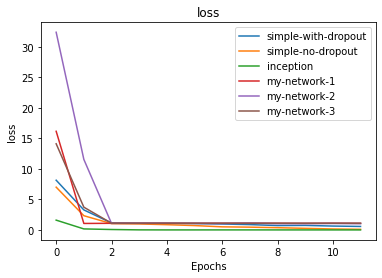

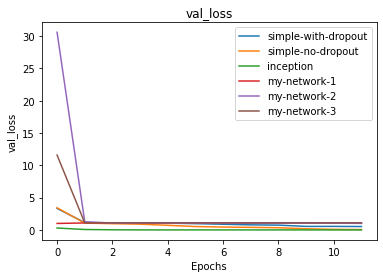

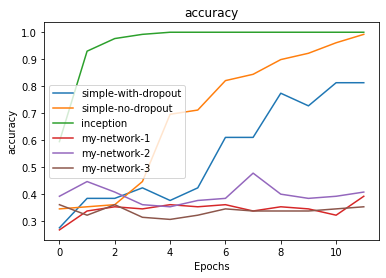

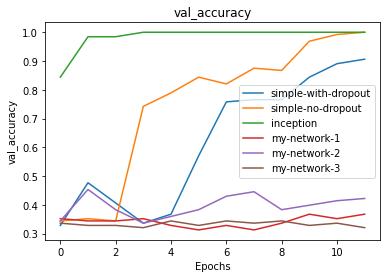

In [17]:
#plt.subplot(2,3,i+1)
def plot_experiment_results(er):
    #plt.title(er.exp_spec.get_expname())
    plt.plot(er.metrics['loss'])
    plt.plot(er.metrics['val_loss'])
    
def plot_metric(metric, ers):
    plt.figure()
    ax = plt.gca()
    ax.set_title(metric)
    ax.set_xlabel("Epochs")
    ax.set_ylabel(metric)
    for name in ers:
        plt.plot(ers[name].metrics[metric], label=name)
    ax.legend()
    
#  for name in ers:
#    plot_experiment_results(ers[name])

plot_metric('loss', ers)
plot_metric('val_loss', ers)
plot_metric('accuracy', ers)
plot_metric('val_accuracy', ers)